In [1]:
from pathlib import Path
import pandas as pd

wt_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20.ehull.csv.gz"), index_col="folder_ind")
diffcsp_no_relax_data = pd.read_csv(Path("generated", "DiffCSP_mp_20_NO_RELAX.ehull.csv.gz"), index_col=0)
diffcsp_data = pd.read_csv(Path("generated", "DiffCSP_mp_20.ehull.csv.gz"), index_col=0)
wt_diffcsppp_no_relax_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20_DiffCSP++_NO_RELAX.ehull.csv.gz"), index_col="folder_ind")
wt_diffcsppp_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20_DiffCSP++.ehull.csv.gz"), index_col=0)
wt_diffcsppp_tol_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20_DiffCSP++_tol=0.1.ehull.csv.gz"), index_col=0)

In [2]:
import gzip
import pickle
from wyckoff_transformer.evaluation import StatisticalEvaluator
with gzip.open(Path("cache", "mp_20", "data.pkl.gz"), "rb") as f:
    datasets_pd = pickle.load(f)
evaluator = StatisticalEvaluator(datasets_pd["test"], pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [3]:
from itertools import repeat
from ast import literal_eval
GENERATED_PATH = Path("generated")

In [4]:
wt_energy_remove_symmetry = pd.read_csv(GENERATED_PATH / "WyckoffTransformer_mp_20.e.remove_symmetry.csv.gz", index_col=0)
wt_energy_fix_symmetry = pd.read_csv(GENERATED_PATH / "WyckoffTransformer_mp_20.e.fix_symmetry.csv.gz", index_col=0)
wt_energy_adjustment = wt_energy_fix_symmetry.energy_per_atom - wt_energy_remove_symmetry.energy_per_atom

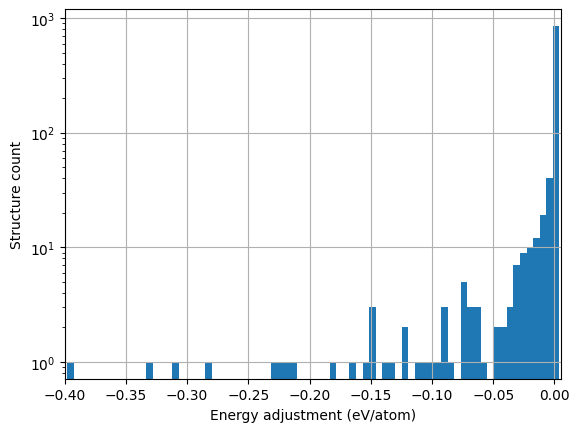

In [47]:
fig, ax = plt.subplots()
(-wt_energy_adjustment).hist(bins=200, ax=ax)
ax.set_xlim(-0.4, 0.005)
ax.set_xlabel("Energy adjustment (eV/atom)")
ax.set_ylabel("Structure count")
ax.set_yscale("log");

In [5]:
wt_data["remove_symmetry_corrected_chgnet_ehull"] = wt_data["corrected_chgnet_ehull"] - wt_energy_adjustment

In [6]:
import json
from typing import Dict
with gzip.open(GENERATED_PATH / "WyckoffTransformer_mp_20.json.gz", "rt") as f:
    generated_wyckoff_transformer = pd.read_json(f)
with gzip.open(GENERATED_PATH / "DiffCSP_mp_20.sites.json.gz", "rt") as f:
    generated_diffcsp = pd.read_json(f)

def check_novelty_record(record: Dict) -> bool:
    return evaluator.generated_to_fingerprint(record) not in evaluator.train_fingerprints
generated_wyckoff_transformer["is_novel"] = generated_wyckoff_transformer.apply(check_novelty_record, axis=1)
generated_diffcsp["is_novel"] = generated_diffcsp.apply(check_novelty_record, axis=1)
generated_wyckoff_transformer["n_elements"] = generated_wyckoff_transformer.species.map(len)
generated_diffcsp["n_elements"] = generated_diffcsp.species.map(len)

In [7]:
for dataset in (wt_data, wt_diffcsppp_data, wt_diffcsppp_tol_data, wt_diffcsppp_no_relax_data):
    dataset["is_novel"] = generated_wyckoff_transformer["is_novel"]
    dataset["n_elements"] = generated_wyckoff_transformer["n_elements"]
    dataset["group"] = generated_wyckoff_transformer["group"]
wt_data = wt_data[wt_data.is_novel]
wt_diffcsppp_data = wt_diffcsppp_data[wt_diffcsppp_data.is_novel]
wt_diffcsppp_no_relax_data = wt_diffcsppp_no_relax_data[wt_diffcsppp_no_relax_data.is_novel]
wt_diffcsppp_tol_data = wt_diffcsppp_tol_data[wt_diffcsppp_tol_data.is_novel]

In [8]:
for dataset in (diffcsp_data, diffcsp_no_relax_data):
    dataset["is_novel"] = generated_diffcsp["is_novel"]
    dataset["n_elements"] = generated_diffcsp["n_elements"]
    dataset["group"] = generated_diffcsp["group"]
diffcsp_data = diffcsp_data[diffcsp_data.is_novel]
diffcsp_no_relax_data = diffcsp_no_relax_data[diffcsp_no_relax_data.is_novel]

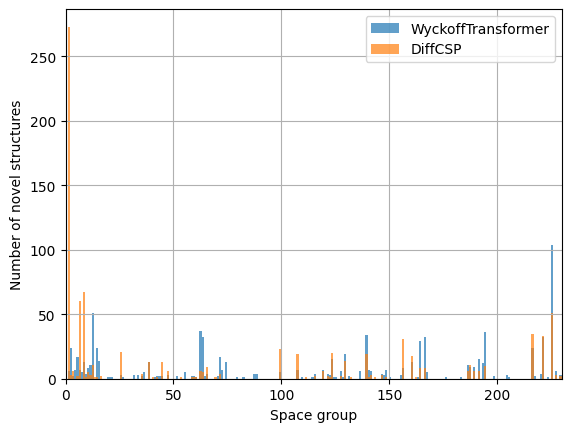

In [9]:
import matplotlib.pyplot as plt
fig_sg, ax_sg = plt.subplots()
wt_data.group.hist(bins=range(1, 231), ax=ax_sg, alpha=0.7, label="WyckoffTransformer")
diffcsp_data.group.hist(bins=range(1, 231), ax=ax_sg, alpha=0.7, label="DiffCSP")
ax_sg.set_xlabel("Space group")
ax_sg.set_ylabel("Number of novel structures")
ax_sg.set_xlim(0, 230)
ax_sg.legend();

In [10]:
def compute_stability(dataset, space_group, stability_threshold = 0.08):
    subset = dataset[dataset.group == space_group]
    return (subset.corrected_chgnet_ehull <= stability_threshold).mean()

In [11]:
import numpy as np
wyckoff_stability = np.array([compute_stability(wt_data, sg) for sg in range(1, 231)])
wy_sg_count = np.array([generated_wyckoff_transformer.group.value_counts().get(sg, 0) for sg in range(1, 231)])

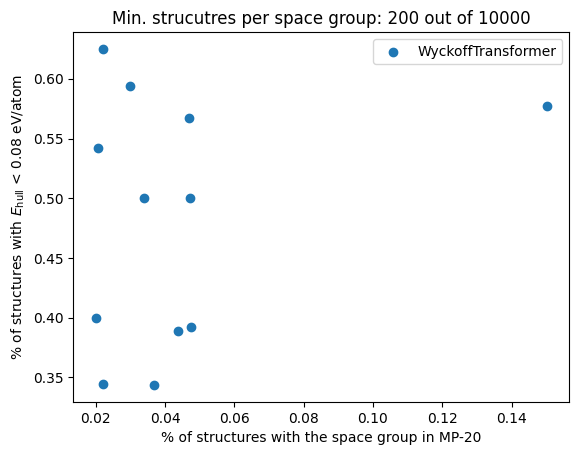

In [12]:
count_threshold = 200
chosen_sgs = (wy_sg_count >= count_threshold)
fig, ax = plt.subplots()
ax.scatter(wy_sg_count[chosen_sgs]/len(generated_wyckoff_transformer),
    wyckoff_stability[chosen_sgs], label=f"WyckoffTransformer")
ax.set_xlabel(r"% of structures with the space group in MP-20")
ax.set_ylabel("% of structures with $E_\\text{hull}$ < 0.08 eV/atom")
ax.set_title(f"Min. strucutres per space group: {count_threshold} out of {len(generated_wyckoff_transformer)}")
ax.legend();

In [13]:
representative_sgs = frozenset(np.where(wy_sg_count >= count_threshold)[0])
wt_representative = wt_data.group.isin(representative_sgs)
wt_diffcsppp_data_representative = wt_diffcsppp_data.group.isin(representative_sgs)

In [17]:
bins=np.linspace(-0.3, 1.8, 35)
stability_threshold = 0.08
def plot_stability():
    fig, ax = plt.subplots(figsize=(6, 4))
    def plot_dataset(dataset, label, column="corrected_chgnet_ehull"):
        dataset[column].hist(bins=bins, ax=ax,
            label=f"{label}, stable: {100*(dataset[column] <= stability_threshold).sum()/len(dataset):.1f}%",
            density=True, alpha=0.5)
    plot_dataset(wt_data, "WyckoffTransformer & pyXtal")
    # plot_dataset(wt_data[~wt_representative], "WyckoffTransformer & pyXtal, other SGs")
    # plot_dataset(wt_diffcsppp_data[wt_diffcsppp_data_representative], "WyckoffTransformer & DiffCSP++, representative SGs")
    # plot_dataset(wt_diffcsppp_data[~wt_diffcsppp_data_representative], "WyckoffTransformer & DiffCSP++, other SGs")
    # plot_dataset(wt_diffcsppp_no_relax_data, "WyckoffTransformer & DiffCSP++ (no relax)")
    # plot_dataset(diffcsp_data, "DiffCSP")
    # plot_dataset(diffcsp_data[diffcsp_data.group == 1], "DiffCSP, SG 1")
    # plot_dataset(diffcsp_data[diffcsp_data.group > 1], "DiffCSP, SG > 1")
    # plot_dataset(wt_diffcsppp_data, "WyckoffTransformer & DiffCSP++")
    # plot_dataset(wt_diffcsppp_tol_data, "WyckoffTransformer & DiffCSP++ (tol=0.1)")
    plot_dataset(wt_data, "WyckoffTransformer & pyXtal, removed symmetry", "remove_symmetry_corrected_chgnet_ehull")
    # plot_dataset(diffcsp_no_relax_data, "DiffCSP (no relax)")
    ax.set_xlabel("$E_\\text{hull}$, eV/atom by CHGNet")
    ax.set_ylabel("Structures pdf")
    ax.axvline(stability_threshold, color="red", label="Stability threshold")
    ax.set_xlim((-0.3, 1.8))
    ax.set_title(f"Stability of novel structures")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"plots/AI4AM_NeurIPS_2024/MP_20_stability.pdf")

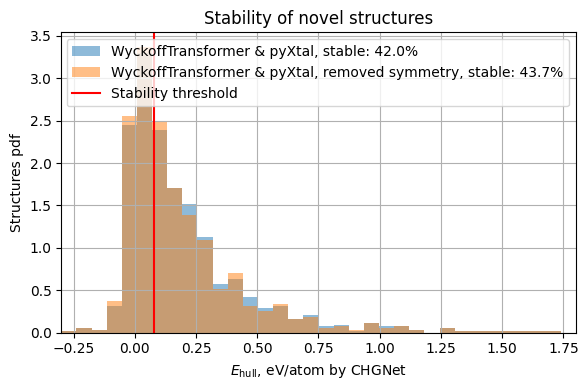

In [18]:
plot_stability()